# Normal Mode Analysis with ProDy
Example: ANM (Anisotropic Network Model)
Use prody_env.yml to create a conda env before running this

See documentation here: http://www.bahargroup.org/prody/manual/reference/dynamics/nma.html


In [ ]:
import prody as pr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Enable ProDy output
pr.confProDy(verbosity='info')

# Parameters
pdb_path = "./data/AF-P04049-F1-model_v6.pdb"

# Other example structues:
# pdb_path = "./data/6H0F_C.pdb"                # A real PDB structure of a very small protein that is actually folded. We don't want NMA to consider this structure as being disordered. 
# pdb_path = "./data/Q13422-AF-v6.pdb"          # An AF2 model with disordered regions.
# pdb_path = "./data/4WMI.pdb"                  # A PDB structure of a typical protein with a small disordered region. We want NMA to recognize the disordered region correctly.
# pdb_path = "./data/AF-Q8NB16-F1-model_v6.pdb" # A AF2 model with a small disordered region. (Same protein as 4WMI)


@> ProDy is configured: verbosity='info'


In [2]:
import prody as pr
import numpy as np

# --- Load and select atoms (could be CA or all heavy atoms) ---
atoms = pr.parsePDB(pdb_path)
atoms = atoms.select("protein and name CA")
N = atoms.numAtoms()
print(f"Number of CA atoms: {N}")

Number of CA atoms: 648


In [3]:
# atomic coordinates stored as a N x 3 array
atoms.getCoords()

array([[-25.757, -25.87 ,   4.018],
       [-22.651, -25.564,   5.059],
       [-19.589, -24.339,   3.334],
       ...,
       [  1.124,  36.621, -69.507],
       [  0.788,  33.11 , -71.056],
       [  2.867,  30.435, -72.077]], shape=(648, 3))

In [4]:
# Visualize the protein using py3Dmol
import py3Dmol
pr.showProtein(atoms)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# # Run this cell if you want to use all heavy atoms

# # --- Load and select atoms (could be all heavy atoms) ---
# atoms = pr.parsePDB(pdb_path)
# N = atoms.numAtoms()
# print(f"Number of CA atoms: {N}")

Number of CA atoms: 5130


In [5]:
# --- Build ANM and modes (CA-only) ---
anm = pr.ANM('CA-ANM')
anm.buildHessian(atoms, cutoff=10)      # 10 is the default cutoff, see documentation
anm.calcModes(n_modes=None)             # if None, all modes will be calculated (same number as atoms)
print(f"Number of modes: {anm.numModes()}") # number of modes is determined by the Hessian matrix used for to build the ANM

@> WARNING More than 6 (64) zero eigenvalues were calculated.


Number of modes: 1880


Eigenvalues of the Hessian (or Kirchhoff) matrix correspond to:
- Vibrational frequencies squared (Hessian/ANM)
- Mode stiffness (GNM)
- Collective motion scales

Interpretation:
- Small eigenvalues → soft modes → large, slow, collective motions
- Large eigenvalues → stiff modes → fast, localized vibrations

This is why the lowest-frequency modes often reveal biologically relevant, large-scale motions.

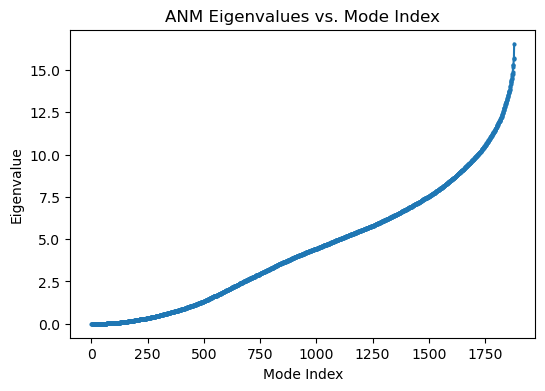

In [6]:
eigvals = anm.getEigvals().round(3)
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(eigvals)), eigvals, marker='o', linestyle='-', markersize=2)
plt.xlabel("Mode Index")
plt.ylabel("Eigenvalue")
plt.title("ANM Eigenvalues vs. Mode Index")
plt.show()

In [7]:
# Structure of the anm_array:
# anm_array is a 3N x N array, where N is the number of atoms.
# Each column of anm_array corresponds to a mode, and contains the x,y,z components of the mode vector for all atoms.
# So, anm_array[:,0] contains the x,y,z components of the first mode vector for all atoms.
# anm_array[:,1] contains the x,y,z components of the second mode vector for all atoms, and so on.
anm_array = anm.getArray()
print(f"anm_array.shape: {anm_array.shape}")
print(f"Number of modes: {anm_array.shape[1]}")
print(f"Number of vectors: {int(anm_array.shape[0]/3)}")
print(f"Number of x,y,z values for all vectors: {anm_array.shape[0]}")

anm_array.shape: (1944, 1880)
Number of modes: 1880
Number of vectors: 648
Number of x,y,z values for all vectors: 1944


Apparently, Prody says you can use py3dmol to visualize it, but I couldn't get it to work, so I wrote my own visualization function below. 
You can also try this:
https://nbviewer.org/github/3dmol/3Dmol.js/blob/f827da26251817ee536838b4b7b5e9d55764606e/py3Dmol/prody.ipynb

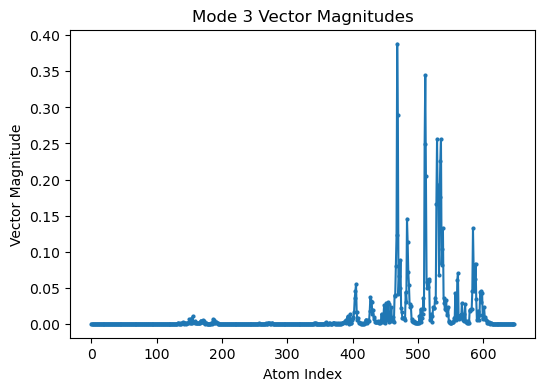

In [40]:
import numpy as np
vecs = anm[1879].getArrayNx3()
magnitudes = np.linalg.norm(vecs, axis=1)
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(magnitudes)), magnitudes, marker='o', markersize=2)
plt.xlabel('Atom Index')
plt.ylabel('Vector Magnitude')
plt.title('Mode 3 Vector Magnitudes')
plt.show()

In [50]:
# Function to plot ANM mode vectors as 3D lines using Plotly (no cones, just lines and points)
def plotly_anm_vector(mode, atom_coords=None, title=None, scale=10):
    """
    Plot ANM mode vectors as 3D line segments using Plotly.

    Parameters
    ----------
    mode : ProDy Mode object or similar (must have .getArrayNx3())
        The mode vector to visualize (e.g., anm[0]).
    atom_coords : numpy.ndarray, shape (N,3), optional
        Cartesian coordinates at which to anchor vectors (e.g., atoms.getCoords()).
        If None, attempts to use mode.getModel().getCoords().
    title : str, optional
        Plot title (default includes mode index if possible).
    scale : float, optional
        Factor to scale the length of vector lines for easier visibility (default 5.0).
    """
    import plotly.graph_objs as go
    import numpy as np

    vecs = mode.getArrayNx3()
    if atom_coords is None:
        if hasattr(mode, "getModel") and mode.getModel() is not None:
            starts = mode.getModel().getCoords()
        else:
            raise ValueError("atom_coords must be provided if mode is not associated with atoms.")
    else:
        starts = atom_coords

    # Compute scaled end points of the vectors
    ends = starts + vecs * scale

    fig = go.Figure()

    # Show atom positions as black markers
    fig.add_trace(go.Scatter3d(
        x=starts[:, 0], y=starts[:, 1], z=starts[:, 2],
        mode='markers',
        marker=dict(size=1, color='black', opacity=0.8),
        name='Atoms (CA)'
    ))

    # Draw line for each vector (from start to scaled end)
    for i in range(starts.shape[0]):
        fig.add_trace(go.Scatter3d(
            x=[starts[i,0], ends[i,0]],
            y=[starts[i,1], ends[i,1]],
            z=[starts[i,2], ends[i,2]],
            mode='lines',
            line=dict(color='royalblue', width=3),
            showlegend=False
        ))

    _title = title
    if _title is None:
        if hasattr(mode, "getIndex"):
            _title = f"Mode {mode.getIndex()} vector as 3D line segments at CA atoms"
        else:
            _title = "Mode Vector as 3D Line Segments at CA Atoms"
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title=_title,
        width=700,
        height=600,
        showlegend=False
    )
    fig.show()


In [59]:
# Example of the slowest mode
plotly_anm_vector(mode=anm[0], atom_coords=atoms.getCoords(), scale=20)


In [ ]:
# Example of the highest frequency mode
plotly_anm_vector(mode=anm[1879], atom_coords=atoms.getCoords(), scale=20)


In [ ]:
# ***AI-generated, need to check if the output makes sense. Use with caution.

# Analyze CA-only ANM by creating a covariance matrix
# --- Covariance from CA modes ---
# ProDy provides covariance directly from CA-only modes
Sigma = pr.calcCovariance(anm)  # shape (3N, 3N), CA-only

# --- Helper: extract 3x3 block (i,j) for CA atoms ---
def block(S, i, j):
    si, sj = slice(3*i, 3*i+3), slice(3*j, 3*j+3)
    return S[si, sj]

# --- Precompute per-CA-atom self blocks and their traces ---
Sigma_ii_trace = np.empty(N)
for i in range(N):
    Sigma_ii_trace[i] = np.trace(block(Sigma, i, i))

# --- Build MSRD and/or Corr matrices (N x N), CA-only ---
MSRD = np.empty((N, N), dtype=np.float32)
Corr = np.empty((N, N), dtype=np.float32)

for i in range(N):
    ti = Sigma_ii_trace[i]
    for j in range(N):
        tj = Sigma_ii_trace[j]
        tij = np.trace(block(Sigma, i, j))
        # Relative RMS displacement, CA-only:
        msrd_ij = max(ti + tj - 2.0*tij, 0.0)
        MSRD[i, j] = np.sqrt(msrd_ij)
        # Cross-correlation (clip for numerical safety), CA-only:
        denom = np.sqrt(max(ti, 1e-12) * max(tj, 1e-12))
        Corr[i, j] = float(np.clip(tij / denom, -1.0, 1.0))



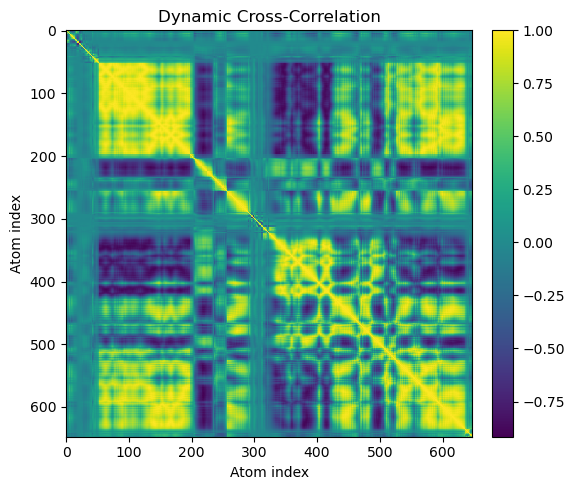

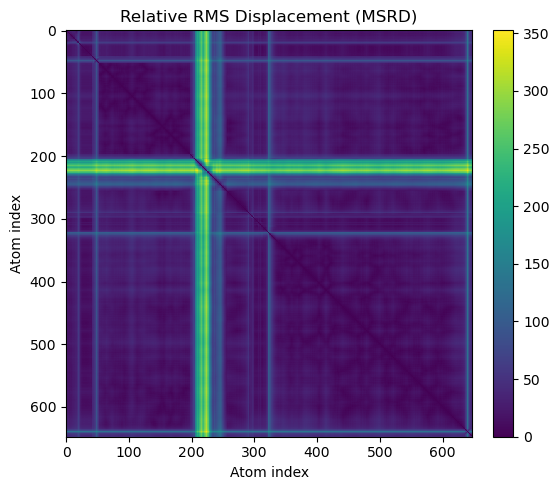

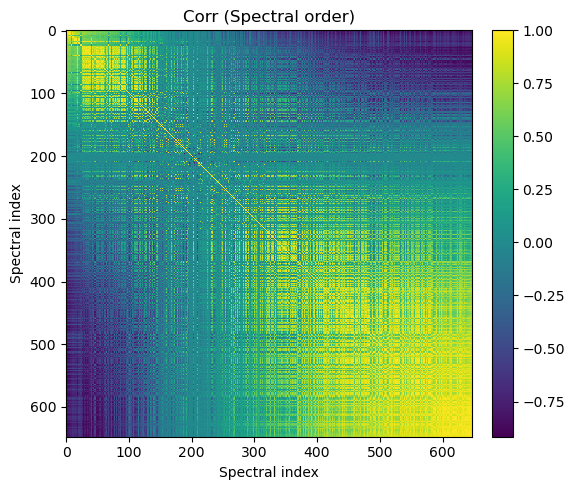

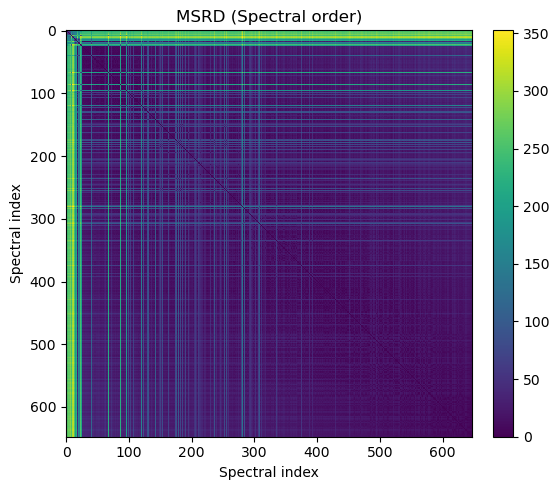

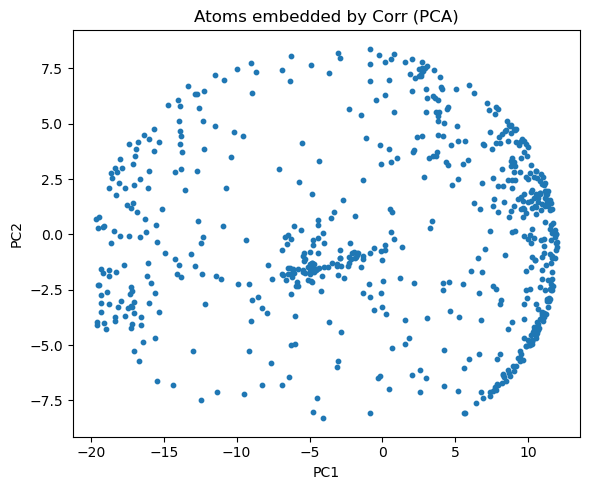

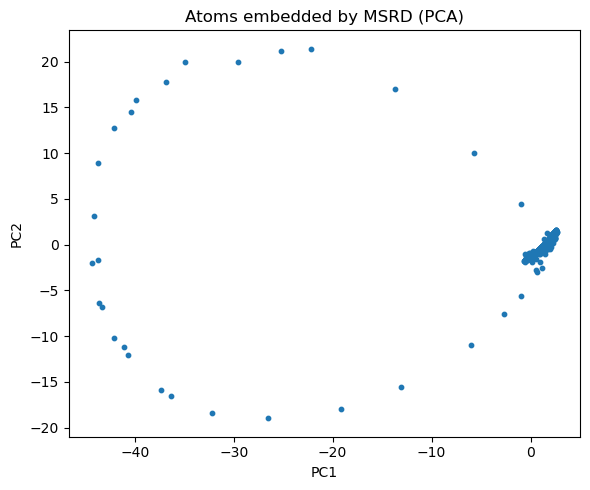

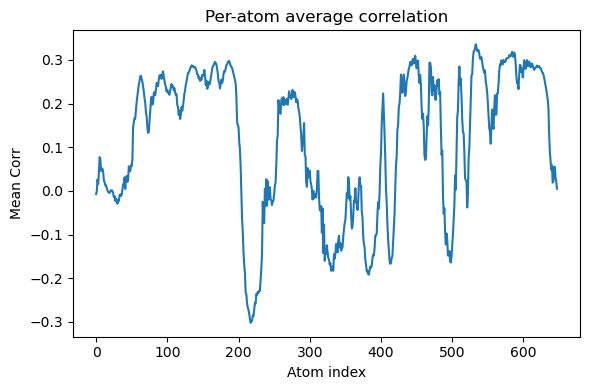

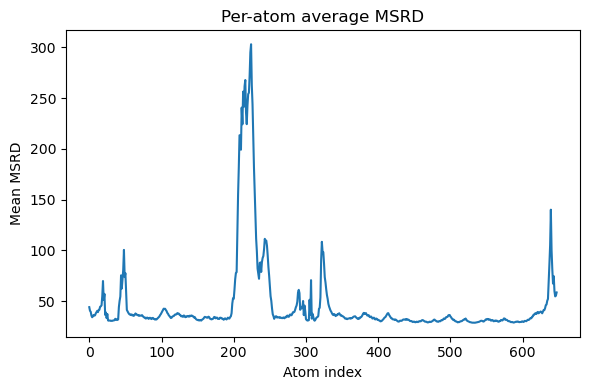

In [61]:
# ***AI-generated, need to check if the output makes sense. Use with caution.

# --- hygiene ---
MSRD = 0.5*(MSRD+MSRD.T); MSRD = np.maximum(MSRD,0)
Corr = 0.5*(Corr+Corr.T); Corr = np.clip(Corr,-1,1)
N = MSRD.shape[0]

# --- spectral order (Fiedler) on Corr ---
A = (Corr+1)/2
d = A.sum(1); d = np.where(d<1e-12,1e-12,d)
L = np.diag(d)-A
w,V = np.linalg.eigh(L)
order = np.argsort(V[:,1]) if N>=2 else np.arange(N)
MSRD_ord = MSRD[np.ix_(order,order)]
Corr_ord = Corr[np.ix_(order,order)]

# --- simple PCA via SVD ---
def pca2(X):
    Xc = X - X.mean(0,keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc@Vt[:2].T

Z_corr = pca2(Corr)
MSRD_std = (MSRD - MSRD.mean(1,keepdims=True)) / (MSRD.std(1,keepdims=True)+1e-12)
Z_msrd = pca2(MSRD_std)

# --- 1) Corr heatmap ---
plt.figure(figsize=(6,5)); plt.imshow(Corr, interpolation='nearest'); plt.title("Dynamic Cross-Correlation")
plt.xlabel("Atom index"); plt.ylabel("Atom index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 2) MSRD heatmap ---
plt.figure(figsize=(6,5)); plt.imshow(MSRD, interpolation='nearest'); plt.title("Relative RMS Displacement (MSRD)")
plt.xlabel("Atom index"); plt.ylabel("Atom index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 3) Corr (spectral order) ---
plt.figure(figsize=(6,5)); plt.imshow(Corr_ord, interpolation='nearest'); plt.title("Corr (Spectral order)")
plt.xlabel("Spectral index"); plt.ylabel("Spectral index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 4) MSRD (spectral order) ---
plt.figure(figsize=(6,5)); plt.imshow(MSRD_ord, interpolation='nearest'); plt.title("MSRD (Spectral order)")
plt.xlabel("Spectral index"); plt.ylabel("Spectral index"); plt.colorbar(fraction=0.046,pad=0.04); plt.tight_layout(); plt.show()

# --- 5) PCA of Corr row-vectors ---
plt.figure(figsize=(6,5)); plt.scatter(Z_corr[:,0], Z_corr[:,1], s=10)
plt.title("Atoms embedded by Corr (PCA)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# --- 6) PCA of MSRD row-vectors ---
plt.figure(figsize=(6,5)); plt.scatter(Z_msrd[:,0], Z_msrd[:,1], s=10)
plt.title("Atoms embedded by MSRD (PCA)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# --- 7) Per-atom summaries ---
plt.figure(figsize=(6,4)); plt.plot(Corr.mean(1)); plt.title("Per-atom average correlation")
plt.xlabel("Atom index"); plt.ylabel("Mean Corr"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(MSRD.mean(1)); plt.title("Per-atom average MSRD")
plt.xlabel("Atom index"); plt.ylabel("Mean MSRD"); plt.tight_layout(); plt.show()

In [62]:
import numpy as np

# Attempt to calculate a directional matrix
# AI-generated, need to check if the output makes sense. Use with caution.
def directional_coupling_along_bond(coords, Sigma):
    """
    coords : (N,3) float array of atomic coordinates (Å)
    Sigma  : (3N,3N) covariance of displacements (same units^2)
             Typically built from ENM/ANM modes (non-rigid modes only).

    Returns
    -------
    radial_msrd : (N,N) float
        RMS of (delta_r_i - delta_r_j) projected on the unit bond vector r_ij/|r_ij|.
        Distance-like, >= 0.
    radial_corr : (N,N) float in [-1,1]
        Signed correlation of motions along the bond direction (together vs. opposite).
    """
    N = coords.shape[0]
    assert Sigma.shape == (3*N, 3*N)

    def blk(i, j):
        si, sj = slice(3*i, 3*i+3), slice(3*j, 3*j+3)
        return Sigma[si, sj]

    # Precompute self/cross 3x3 blocks as needed
    Sii = [blk(i, i) for i in range(N)]

    radial_msrd = np.zeros((N, N), dtype=float)
    radial_corr = np.zeros((N, N), dtype=float)

    eps = 1e-12
    for i in range(N):
        for j in range(N):
            if i == j:
                # zero relative motion by definition; correlation undefined -> set 1.0
                radial_msrd[i, j] = 0.0
                radial_corr[i, j] = 1.0
                continue

            rij = coords[j] - coords[i]
            norm = np.linalg.norm(rij)
            if norm < 1e-9:
                # overlapping coordinates: skip or set NaN
                radial_msrd[i, j] = 0.0
                radial_corr[i, j] = 0.0
                continue
            e = rij / norm  # unit bond direction i->j

            Sij = blk(i, j)
            Sji = Sij.T  # should be transpose for symmetric Sigma

            # Variance of ( (dr_i - dr_j) · e ) = eᵀ (Sii + Sjj - Sij - Sji) e
            S_rel = Sii[i] + Sii[j] - Sij - Sji
            var_rel = float(e @ S_rel @ e)
            var_rel = max(var_rel, 0.0)      # numeric safety
            radial_msrd[i, j] = np.sqrt(var_rel)

            # Signed correlation along e: (eᵀ Sij e) / sqrt( (eᵀ Sii e)(eᵀ Sjj e) )
            num = float(e @ Sij @ e)
            den = np.sqrt(max(float(e @ Sii[i] @ e), eps) * max(float(e @ Sii[j] @ e), eps))
            radial_corr[i, j] = np.clip(num / den, -1.0, 1.0)

    return radial_msrd, radial_corr

# Example usage:
# coords: shape (N,3); Sigma: shape (3N,3N)
coords = atoms.getCoords()
radial_msrd, radial_corr = directional_coupling_along_bond(coords, Sigma)

In [63]:
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Heatmap(
        z=radial_corr,
        x=np.arange(radial_corr.shape[1]),
        y=np.arange(radial_corr.shape[0]),
        colorbar=dict(title='radial_corr'),
        colorscale='Viridis',
        zmin=-1.0, zmax=1.0,
        hovertemplate="Atom index X: %{x}<br>Atom index Y: %{y}<br>Value: %{z:.3f}<extra></extra>"
    )
)

fig.update_layout(
    title='radial_corr',
    xaxis_title="Atom index",
    yaxis_title="Atom index",
    width=600,
    height=500
)
fig.show()